In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
import tensorflow
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


In [37]:
#Read data 
#sample = pd.read_csv(data_dir + 'SampleSubmission.csv')
data_dir = 'facial-keypoints-detection/'
lookid_data = pd.read_csv(data_dir + 'IdLookupTable.csv')
train_data = pd.read_csv(data_dir + 'training.csv')
test_data = pd.read_csv(data_dir + 'test.csv')

In [38]:
IMG_SIZE = 96 # image size 96 x 96 pixels

def show_keypoints(image, keypoints):
    '''
    Show image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
    '''
      
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')
        
def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    '''
    Show images with keypoints in grids
    Args:
        df (DataFrame): data (M x N)
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if show image with keypoints
    '''
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32)\
                .reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32)\
                        .reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

In [41]:
lookid_data.head(10)

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
5,6,1,left_eye_inner_corner_y,NaN
6,7,1,left_eye_outer_corner_x,NaN
7,8,1,left_eye_outer_corner_y,NaN
8,9,1,right_eye_inner_corner_x,NaN
9,10,1,right_eye_inner_corner_y,NaN


In [43]:
train_data.head(2)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


In [46]:
training.head(2).T

,0,1
left_eye_center_x,66.0336,64.3329
left_eye_center_y,39.0023,34.9701
right_eye_center_x,30.227,29.9493
right_eye_center_y,36.4217,33.4487
left_eye_inner_corner_x,59.5821,58.8562
left_eye_inner_corner_y,39.6474,35.2743
left_eye_outer_corner_x,73.1303,70.7227
left_eye_outer_corner_y,39.97,36.1872
right_eye_inner_corner_x,36.3566,36.0347
right_eye_inner_corner_y,37.3894,34.3615


In [51]:
print(train_data.columns)
print('Shape')
print(train_data.shape)


Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')
Shape
(7049, 31)


In [55]:
print('28 features with NA')
print(train_data.isnull().any().value_counts())

print('Number of images', len(training))
print('Number of images when we drop data with any NA:', len(train_data.dropna()))

print('Images with the following missing')
print(training.isna().sum())

28 features with NA
True     28
False     3
dtype: int64
Number of images 7049
Number of images when we drop data with any NA: 2140
Images with the following missing
left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner

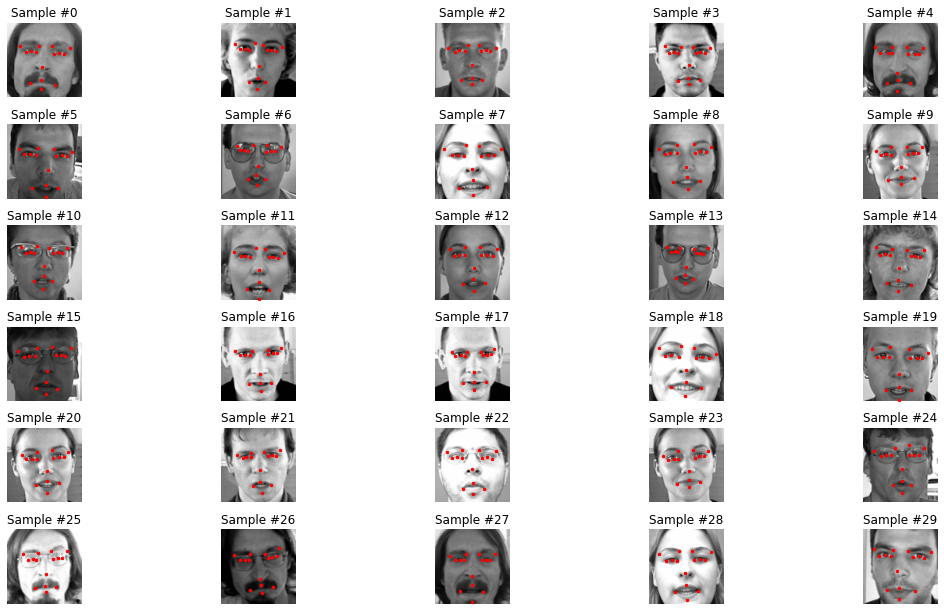

In [64]:
# examples of images with marks for facial keypoints
show_images(train_data, range(30))

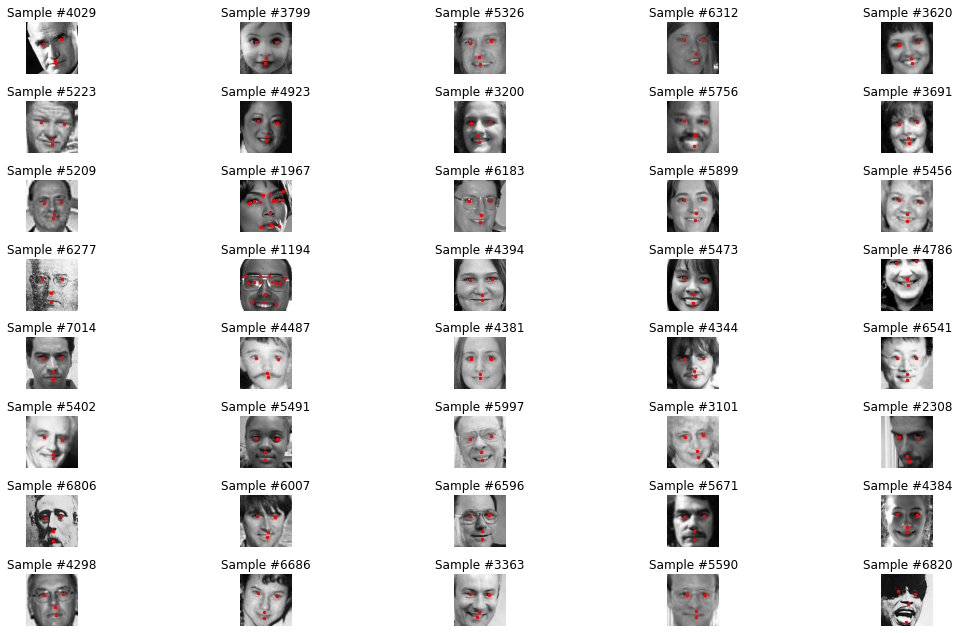

In [61]:
# examples of images with missing data
missing_any_data = train_data[train_data.isnull().any(axis=1)]
idxs = np.random.choice(missing_any_data.index, 40)
show_images(train_data, idxs)
#Most missing features seem to be rotated images
#Others: blurry, hair over eye, glasses, 

In [13]:
imag = []
for i in range(0,len(train_data['Image'])):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)
    
image_list = np.array(imag,dtype = 'float')


In [15]:
len(image_list)

2284

In [16]:
X_train = image_list.reshape(-1,96,96,1)

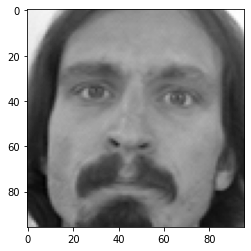

In [17]:
plt.imshow(X_train[0].reshape(96,96),cmap='gray')
plt.show()

In [18]:
#training2 = training.drop('Image',axis = 1)
training2 = training_na.drop('Image',axis = 1)


y_train = []
for i in range(0,len(training2)):
    y = training2.iloc[i,:]
    y_train.append(y)
    
y_train = np.array(y_train,dtype = 'float')

In [20]:
model = Sequential([Flatten(input_shape=(96,96)),
                         Dense(128, activation="relu"),
                         Dropout(0.1),
                         Dense(64, activation="relu"),
                         Dense(30)
                         ])

In [21]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)       

In [22]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [23]:
model.fit(X_train,y_train,epochs = 50,batch_size = 256,validation_split = 0.2)

Epoch 1/50
8/8 [==============================] - 91s 11s/step - loss: 974.5916 - mae: 24.4628 - val_loss: 1816.6433 - val_mae: 39.6074
Epoch 2/50
8/8 [==============================] - 57s 7s/step - loss: 87.9783 - mae: 7.4872 - val_loss: 1386.6230 - val_mae: 34.2894
Epoch 3/50
8/8 [==============================] - 42s 5s/step - loss: 51.7341 - mae: 5.6932 - val_loss: 643.2236 - val_mae: 23.1471
Epoch 4/50
8/8 [==============================] - 40s 5s/step - loss: 36.5738 - mae: 4.7818 - val_loss: 281.4933 - val_mae: 15.0444
Epoch 5/50
8/8 [==============================] - 42s 5s/step - loss: 32.0463 - mae: 4.4840 - val_loss: 135.5990 - val_mae: 10.0825
Epoch 6/50
8/8 [==============================] - 42s 5s/step - loss: 29.3737 - mae: 4.2867 - val_loss: 96.6918 - val_mae: 8.3118
Epoch 7/50
8/8 [==============================] - 42s 5s/step - loss: 27.2571 - mae: 4.1204 - val_loss: 79.5805 - val_mae: 7.4268
Epoch 8/50
8/8 [==============================] - 43s 5s/step - loss: 26.31

In [ ]:
#Rotate and data augment 